<a href="https://colab.research.google.com/github/pierredumontel/subway_validations-/blob/main/Notebook/Traitement_des_validations_du_re%CC%81seau_de_transport_d'Ile_de_France_a%CC%80_comple%CC%81ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-projet Apache Spark

Merci d'indiquer les noms composant le binôme :

|Nom | Prénom|
|---|---|
| DUMONTEL | Pierre |
| ROUET | William |

L'objectif est de collecter les données de validations quotidiennes de titres de transport de la région parisienne, disponibles en Open Data sur le site de Mobilités Ile-de-France.

On se concentrera sur le **réseau ferré** exclusivement pour cet exercice.

## Installation de Spark

Apache Spark n'est pas disponible en standard sur Google Colab.
Procéder à son installation, ainsi qu'à son initialisation pour réaliser le traitement à venir.

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 198 kB 52.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=0c9bf4f32a94c9c511ed3c1394ed693bf39fb7beada6a51e43193aae18c2b851
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pyspark

sc = pyspark.SparkContext()
sql_sc = pyspark.SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark = (pyspark.sql.SparkSession
         .builder
         .appName('GasPrice')
         .getOrCreate()
)

## Récupération des données

Sur le site https://data.iledefrance-mobilites.fr, récupérer les données de validation par jour.

Exemple :
https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/information/

Récupérer les données de S1 2020 et S2 2021 pour disposer d'une année complète.

On utilisera pour ce faire les commandes de téléchargement de fichiers depuis un site (pas de chargement manuel).

__Attention__ : prévoir une vingtaine de minutes pour le téléchargement, au moins une première fois, et donc une copie sur Google Drive si Google Colab est utilisée, afin d'éviter ce temps d'attente lors de sessions de travail successives.

**Nb : les fichiers sont chargés un par un. Après s'être téléchargé, les fichiers prennent le nom "?format=csv". Et les renomme tour à tour S_TWO_twenty.csv pour le second semestre de 2020 et S_ONE_twenty_one.csv pour le premier semestre de 2021.**


In [ ]:
!curl -O https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.3M    0 47.3M    0     0   151k      0 --:--:--  0:05:19 --:--:--  141k


In [ ]:
!ls -lh

total 48M
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data
-rw-r--r-- 1 root root  48M Dec 17 15:51 S_TWO_Twenty.csv


In [ ]:
!curl -O https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M    0 24.7M    0     0   189k      0 --:--:--  0:02:13 --:--:--  218k


In [ ]:
!ls -lh

total 73M
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data
-rw-r--r-- 1 root root  25M Dec 17 15:54 S_ONE_twenty_one.csv
-rw-r--r-- 1 root root  48M Dec 17 15:51 S_TWO_Twenty.csv


### Commentaires sur les données disponibles sur ce portail

Investiguer les données diponibles sur le portail.

Question : peut-on constituer un historique de données s'étendant sur les trois dernières années (2019 à 2021) ?


**A cette adresse https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations/table/?sort=types_de_validations, il y a les données de validation du S1 2019, mais rien pour le S2 2019. Rien n'est renseigné pour le S1 2020 également. **

## Lecture des fichiers dans Spark

Lire les fichiers en choisissant les bonnes options de lecture.
Concaténer les données en une seule table.

In [ ]:
S_TWO_twenty =spark.read.csv('/content/S_TWO_Twenty.csv', sep=';', header = True)
S_ONE_twenty_one =spark.read.csv('/content/S_ONE_twenty_one.csv', sep=';', header = True)

Concaténation des fichiers

In [ ]:
validations_ddf = S_ONE_twenty_one .union(S_TWO_twenty)

## Validation

Si vous avez appelé votre dataframe `validations_ddf`, le test suivant ne doit pas générer d'erreur.

In [ ]:
assert validations_ddf.count() == 1_316_287, "Le nombre de lignes ne correspond pas"

Dans le cas où ce code génère une erreur, il s'agit probablement d'un problème de récupération ou de lecture des deux fichiers.

## Préparation des données

Réaliser les transformations nécessaires pour exploiter ces données :
- préparation des dates
- transformation du nombre de validation

### Explication pour le nombre de validations

Analyser les valeurs prises par ce champ et déterminer le problème.
Présenter votre stratégie pour remédier à ce choix de codage par Mobilités Ile-de-France.

In [ ]:
validations_ddf = (validations_ddf
 .withColumn("nb_vald",validations_ddf.nb_vald.cast('int'))
 .withColumn("jour",validations_ddf.jour.cast('timestamp'))
)

validations_ddf.printSchema()

root
 |-- jour: timestamp (nullable = true)
 |-- code_stif_trns: string (nullable = true)
 |-- code_stif_res: string (nullable = true)
 |-- code_stif_arret: string (nullable = true)
 |-- libelle_arret: string (nullable = true)
 |-- id_refa_lda: string (nullable = true)
 |-- categorie_titre: string (nullable = true)
 |-- nb_vald: integer (nullable = true)



In [ ]:
validations_ddf.show(5)

+-------------------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|               jour|code_stif_trns|code_stif_res|code_stif_arret|libelle_arret|id_refa_lda|categorie_titre|nb_vald|
+-------------------+--------------+-------------+---------------+-------------+-----------+---------------+-------+
|2021-01-04 00:00:00|           100|          110|             47|       BALARD|      71073|              ?|    110|
|2021-01-04 00:00:00|           100|          110|             47|       BALARD|      71073|    NAVIGO JOUR|      7|
|2021-01-04 00:00:00|           100|          110|            476|  LOUIS BLANC|      71407|              ?|     24|
|2021-01-04 00:00:00|           100|          110|            476|  LOUIS BLANC|      71407|    AUTRE TITRE|    132|
|2021-01-04 00:00:00|           100|          110|            478|LOUISE MICHEL|      73667|            TST|    226|
+-------------------+--------------+-------------+--------------

Choix de codage de Mobilités Ile-de-France : le nombre de validation est renseigné par catégories de titre sur une journée. C'est à dire que pour obtenir le nombre total de validations par jour sur une seule ligne, il faudrait sommer le nombre de validations par catégories de titre pour un jour. 
Ou regrouper toutes les mêmes dates ensemble

## Détermination des principales catégories de titre

Différentes catégories de titre sont utilisées sur le réseau.

Déterminer les deux catégories principalement utilisées. Seules ces catégories seront utilisées dans les travaux ci-après (les utiliser comme filtre sur les validations dans la suite).

In [ ]:
import pyspark.sql.functions as F 
validations_ddf.groupBy('categorie_titre').agg(F.count('nb_vald').alias('effectif')).sort('effectif', ascending = False).show(2)

+---------------+--------+
|categorie_titre|effectif|
+---------------+--------+
|         NAVIGO|  158876|
|      IMAGINE R|  156147|
+---------------+--------+
only showing top 2 rows



In [ ]:
(validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
)

DataFrame[jour: timestamp, code_stif_trns: string, code_stif_res: string, code_stif_arret: string, libelle_arret: string, id_refa_lda: string, categorie_titre: string, nb_vald: int]

## Visualisation du trafic dans une station

Visualiser le trafic à la gare de Lyon pour les deux catégories de titre principales.

Attention à gérer le cas des gares (comme la gare de Lyon) présentes sur plusieurs lignes et dont le libellé apparaît donc sur plusieurs lignes. Investiguer ce cas avant de déterminer la bonne façon de calculer le nombre de validations pour la gare de Lyon.

In [ ]:
# Votre code mettant en évidence le cas des gares sur plusieurs lignes

# La colonne "code_stif_arret" donne le code de l'arret et/ou de la station, on voit que la Gare de Lyon accueille plusieurs arrets : 
(validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
.filter(validations_ddf.libelle_arret == "GARE DE LYON")
 .groupBy('code_stif_arret').agg(F.sum('nb_vald').alias('nb de vald par arret'))
 .show()
)


+---------------+--------------------+
|code_stif_arret|nb de vald par arret|
+---------------+--------------------+
|            317|             2874070|
|            306|             2826705|
|            307|              415520|
+---------------+--------------------+



In [ ]:
# Votre code visualisant le trafic à la gare de Lyon
(validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
 .filter(validations_ddf.libelle_arret == "GARE DE LYON")
 .groupBy('libelle_arret','categorie_titre','code_stif_arret').agg(F.sum('nb_vald').alias('effectif'))
 .show()
)

+-------------+---------------+---------------+--------+
|libelle_arret|categorie_titre|code_stif_arret|effectif|
+-------------+---------------+---------------+--------+
| GARE DE LYON|         NAVIGO|            306| 2168115|
| GARE DE LYON|         NAVIGO|            317| 2285528|
| GARE DE LYON|      IMAGINE R|            306|  658590|
| GARE DE LYON|      IMAGINE R|            317|  588542|
| GARE DE LYON|         NAVIGO|            307|  340638|
| GARE DE LYON|      IMAGINE R|            307|   74882|
+-------------+---------------+---------------+--------+



In [ ]:
(validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
 .filter(validations_ddf.libelle_arret == "GARE DE LYON")
 .groupBy('libelle_arret','categorie_titre').agg(F.sum('nb_vald').alias('nb_de_vald_par_arret'))
 .show()
)

+-------------+---------------+--------------------+
|libelle_arret|categorie_titre|nb_de_vald_par_arret|
+-------------+---------------+--------------------+
| GARE DE LYON|         NAVIGO|             4794281|
| GARE DE LYON|      IMAGINE R|             1322014|
+-------------+---------------+--------------------+



## Fluctuation du trafic hebdomadaire

Calculer le trafic total et le pourcentage par jour de la semaine sur l'ensemble du réseau.

Trier le résultat par ordre décroissant de validations.

Note : considérer l'usage d'une fonction analytique (`Window.partitionBy()`).


dayofweek = sunday is 1, monday is 2,…, Saturday is 7 

In [ ]:
from pyspark.sql.functions import col, round

prt_df = (validations_ddf
            .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
            .withColumn('jour_semaine', F.dayofweek(F.col('jour')))
            .withColumn('num_semaine', F.weekofyear(F.col('jour')))
            .toPandas()
            )

(validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
 .withColumn('jour_semaine', F.dayofweek(F.col('jour')))
 .withColumn('num_semaine', F.weekofyear(F.col('jour')))
 .groupBy('jour_semaine').agg(F.sum('NB_VALD').alias('nb_vald_sumcum_byday')).sort('nb_vald_sumcum_byday', ascending = False)
 .withColumn('% of total', round((F.col('nb_vald_sumcum_byday')/prt_df['nb_vald'].sum()),2))
 .show()
)

+------------+--------------------+----------+
|jour_semaine|nb_vald_sumcum_byday|% of total|
+------------+--------------------+----------+
|           5|            85290097|      0.17|
|           4|            84481016|      0.17|
|           3|            82751916|      0.17|
|           6|            81437580|      0.17|
|           2|            78153770|      0.16|
|           7|            49805311|       0.1|
|           1|            30896857|      0.06|
+------------+--------------------+----------+



In [ ]:
(validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
 .agg(F.sum(F.col('nb_vald')))
 ).show()

+------------+
|sum(nb_vald)|
+------------+
|   492816547|
+------------+



## Analyse de l'impact du reconfinement d'octobre 2020

Mettre en évidence graphiquement l'impact du reconfinement.

N'utiliser que les catégories de titre _IMAGINE R_ et _Navigo_.


Le reconfinement d'octobre 2020 fut acté le 29 octobre 2020. L'idée serait de visualiser le nombre de validation par jour avant et après cette date. 

In [ ]:
import seaborn as sns 
import plotly.graph_objects as go
sns.set()


prt2_df = (validations_ddf
            .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
            .groupBy('jour').agg(F.sum('nb_vald').alias('tot_vald'))
            .toPandas()
            )


data_prt = [go.Scatter(x = prt2_df.sort_values('jour')['jour'],
                         y = prt2_df.sort_values('jour')['tot_vald'])]


    # Disposition (layout)
layout = dict(
        title='Analyse quotidienne du trafic 07/2020-05/2021',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1d',
                         step='day',
                         stepmode='backward'),
                    dict(count=6,
                         label='6d',
                         step='day',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
)

    # Affichage (version 4 de plotly nécessaire pour Colab)
fig = go.Figure(
        data=data_prt,
        layout=layout)
    
fig.show()

#### Bonus

Calculer la moyenne glissante sur 7 jours par categorie de titre pour réduire les variations hebdomadaires.

In [ ]:
rolling_prt = (validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
 .groupBy('JOUR').agg(F.sum('NB_VALD').alias('nb_vald_sumcum_byday'))
 .toPandas()
)

rolling_prt = rolling_prt.sort_values('JOUR', ascending=True)
rolling_prt["MA"] = rolling_prt['nb_vald_sumcum_byday'].rolling(window=7, center = False).mean()
rolling_qui_glisse = [go.Scatter(x = rolling_prt.sort_values('JOUR')['JOUR'],
                         y = rolling_prt.sort_values('JOUR')['MA'])]


    # Disposition (layout)
layout = dict(
        title='Moyenne glissante par période de 7 jours avec rolling',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1d',
                         step='day',
                         stepmode='backward'),
                    dict(count=6,
                         label='6d',
                         step='day',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
)

    # Affichage (version 4 de plotly nécessaire pour Colab)
fig = go.Figure(
        data=rolling_qui_glisse,
        layout=layout)
    
fig.show()

# Modélisation avec Apache Spark

On essaie de faire un modèle basique de prévision du trafic dans les 7 prochains jours, pour une station.

Apache Spark MLlib n'intègre pas de modèle pour les séries chronologiques.

L'approche classique est alors d'utiliser une technique de régression classique (régression linéaire bien sûr, mais aussi RandomForestRegressor par exemple).

Pour une première version simple, utiliser un vecteur constituer des validations sur les 14 jours précédents (X) pour prédire les validations du jour (y). Dans cette version, on utilisera une `LinearRegression` ou un `RandomForestRegressor`, au choix.

Le code doit comporter :
- la préparation des _features_ (X)
- la constitution d'un ensemble d'apprentissage et de test
- l'entrainement d'un modèle
- le mesure de la performance du modèle : RMSE

Rappel : ne travailler que sur les deux catégories de titre principales.


## Première version simple 

Hypothèses : 
0n filtre le jeu de données sur les 2 principales catégories de titres et sur une seule station (via "LIBELLE_ARRET"). 
On somme le nombre de validation par jour (dans le cas où il y a plusieurs arrets dans une même station)

In [ ]:
import pyspark.sql.functions as F 
first_one = (validations_ddf
 .filter((validations_ddf.categorie_titre == "NAVIGO") | (validations_ddf.categorie_titre == "IMAGINE R"))
 .filter(validations_ddf.libelle_arret == "GARE DE LYON")
 .groupBy('jour').agg(F.sum('nb_vald').alias('tot_vald'))
 .sort('jour', ascending = True)
 .toPandas()
)

first_one.head()

,jour,tot_vald
0,2020-07-01,25190
1,2020-07-02,25507
2,2020-07-03,24853
3,2020-07-04,15121
4,2020-07-05,14846


#### Préparations des features (X)



*   On construit un jeu de données avec 14 colonnes représentant le nombre total de validations pour une station les 14 jours précédents la variable à prédire (dans la première colonne, la valeur de la veille de la variable dépendante).
*   Le premier élément du vecteur à prédire est la première observation avec un historique complet de 14 jours (soit le 15 juillet 2020). 


In [ ]:
import numpy as np
import pandas as pd 
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


X = pd.DataFrame(rolling_window(first_one['tot_vald'].to_numpy(), 14), 
                  columns=['lag14','lag13','lag12','lag11','lag10',
                           'lag9','lag8','lag7','lag6','lag5',
                           'lag4','lag3','lag2','lag1'])

X = X[['lag1','lag2','lag3','lag4','lag5',
         'lag6','lag7','lag8','lag9','lag10',
         'lag11','lag12','lag13','lag14']]
X = X.drop(index=321)
X.head()

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
0,22244,21583,20081,22055,25534,25732,25605,27075,26651,14846,15121,24853,25507,25190
1,28446,22244,21583,20081,22055,25534,25732,25605,27075,26651,14846,15121,24853,25507
2,23861,28446,22244,21583,20081,22055,25534,25732,25605,27075,26651,14846,15121,24853
3,26863,23861,28446,22244,21583,20081,22055,25534,25732,25605,27075,26651,14846,15121
4,24656,26863,23861,28446,22244,21583,20081,22055,25534,25732,25605,27075,26651,14846


In [ ]:
dep_mask = (first_one['jour'] > "2020-07-14") & (first_one['jour'] <= "2021-05-31")
y = first_one.loc[dep_mask]
y = y[["tot_vald"]]
y = y.reset_index()
y = y.drop(columns='index')
y.head()

,tot_vald
0,28446
1,23861
2,26863
3,24656
4,24930


In [ ]:
first_one.shape, y.shape, X.shape

((335, 2), (321, 1), (321, 14))

#### Constitution d'ensembles d'apprentissage et de test 

On conserve les deux premiers tiers du jeu de données pour entrainer le modèle, le dernier tier fait office d'échantillon test.

In [ ]:
Xtrain = X.iloc[:224]
Xtest = X.iloc[224:]
ytrain = y.iloc[:224]
ytest = y.iloc[224:]

y_test = ytest.reset_index()
y_test = y_test.drop(columns='index')
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((224, 14), (224, 1), (97, 14), (97, 1))

#### Entrainement du modèle 

On entraine le modèle via une régression linéaire et une régression par forêts aléatoires

In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
lm = linear_model.fit(X=Xtrain, y=ytrain)
y_pred = lm.predict(Xtest)
lm.coef_, lm.intercept_

(array([[ 0.62417375,  0.01316151,  0.15612874,  0.06534432, -0.15817056,
          0.22890722,  0.57312444, -0.37511033, -0.15220661, -0.0727028 ,
         -0.0701021 ,  0.09137284, -0.10121205,  0.14161696]]),
 array([649.21530358]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor()

RF_model = RFreg.fit(X=Xtrain,y=ytrain)
y_pred = lm.predict(Xtest)
RF_model.feature_importances_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



array([0.16417076, 0.02196145, 0.01546741, 0.00907964, 0.0047817 ,
       0.00717546, 0.70897223, 0.01068218, 0.00935022, 0.0094512 ,
       0.00926986, 0.0037947 , 0.00842344, 0.01741976])

#### Mesure de la performance du modèle 

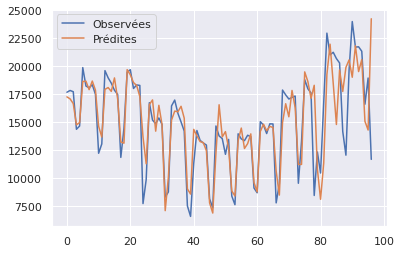

Le RMSE de la régression linéaire est de 2525 personnes.


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

rmse_lm = sqrt(mean_squared_error(y_test,y_pred))
plt.plot(y_test, label="Observées")
plt.plot(y_pred, label="Prédites")
plt.legend()
plt.show()
print("Le RMSE de la régression linéaire est de {:.0f} personnes.".format(rmse_lm))

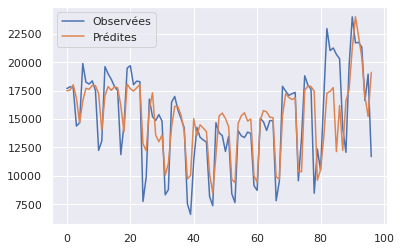

Le RMSE de la régression par forêts aléatoires est de 2490 personnes.


In [ ]:
y_RFpred = RF_model.predict(Xtest)
rmse_RF = sqrt(mean_squared_error(y_test,y_RFpred))
plt.plot(y_test, label="Observées")
plt.plot(y_RFpred, label="Prédites")
plt.legend()
plt.show()

print("Le RMSE de la régression par forêts aléatoires est de {:.0f} personnes.".format(rmse_RF))

## Amélioration du modèle

Discuter des façons d'améliorer cette première version du modèle.



*  L'objectif intial, non atteint jusqu'à présent, est de prédire le trafic sur un intervalle de 7 jours, et non pas 1. L'objectif serait ainsi d'implémenter un modèle capable de prédire 7 variables dépendantes dans un même modèle. 
Nous avons ainsi exploré 2 méthodes :


1.   MultiOutputRegressor de Sklearn
2.   La méthode Prophet de la librairie fbprophet 



## OPTION : implémentation des améliorations

Implémenter tout ou partie des suggestions d'amélioration.

**Cette partie est facultative et sera bonifiante si les éléments contribués sont probants.**

### Première méthode explorée : Multiple outputs regression 

#### Préparation des features, puis des ensembles d'apprentissage et de test 

Hypothèses : 
*   La matrice des variables dépendantes Multi_y contient 7 colonnes représentant le nombre total de validations pour une station (dans la première colonne, le nombre correspondant à la date qui nous est la plus proche dans le temps).
*   La matrice des variables explicatives Multi_X contient 14 colonnes représentant le nombre total de validations pour une station (dans la première colonne, les nombres correspondants à la veille des éléments de la dernière colonne de Multi_y).



In [ ]:
Multi_y = first_one.loc[dep_mask]
Multi_y = pd.DataFrame(rolling_window(Multi_y ['tot_vald'].to_numpy(), 7), 
                  columns=['y7','y6','y5','y4','y3','y2','y1'])
Multi_y = Multi_y[['y1','y2','y3','y4','y5','y6','y7']]
Multi_X = X.drop(index={320,319, 318,317,316,315})
Multi_y.shape, Multi_X.shape

((315, 7), (315, 14))

In [ ]:
MXTrain = Multi_X.iloc[:208]
MXTest = Multi_X.iloc[208:]
MYTrain = Multi_y.iloc[:208]
MYTest = Multi_y.iloc[208:]
MY_Test = MYTest.reset_index()
MY_Test = MY_Test.drop(columns='index')

MXTrain.shape,MXTest.shape,MYTrain.shape,MYTest.shape

((208, 14), (107, 14), (208, 7), (107, 7))

#### Entrainement du modèle

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

Multi = MultiOutputRegressor(LinearRegression())
model_multi = Multi.fit(MXTrain, MYTrain)
My_pred = model_multi.predict(MXTest)
My_pred_df = pd.DataFrame(My_pred)

#### Mesure de la performance du modèle

In [ ]:
rmse_multi = sqrt(mean_squared_error(MY_Test[['y1','y2','y3','y4','y5','y6','y7']],My_pred_df[[0,1,2,3,4,5,6]]))
print("Le RMSE de la régression linéaire en Multiouput est de {:.0f} personnes.".format(rmse_multi))

Le RMSE de la régression linéaire en Multiouput est de 2470 personnes.


Ce RMSE est plus faible que ceux précedemment calculés dans la régression linéaire et la régression par forêts aléatoires. 

### Deuxième méthode explorée : Prophet

#### Préparation des features (y,X) et constitution des ensembles d'apprentissage et de test 

In [ ]:
from fbprophet import Prophet

Train = first_one.iloc[:224]
Test = first_one.iloc[224:]

df_proph = Train[["jour","tot_vald"]]
Test_proph = Test[["jour","tot_vald"]]

df_proph = df_proph.rename(columns={"jour": "ds", "tot_vald": "y"})
Test_proph = Test_proph.rename(columns={"jour": "ds", "tot_vald": "y"})

proph_test = Test_proph.reset_index()
proph_test = proph_test.drop(columns='index')

#### Entrainement du modèle

In [ ]:
m = Prophet()
m.add_country_holidays(country_name='FR')
m.fit(df_proph)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_df = m.predict(proph_test)
forecast_df[['ds','yhat']].tail(7)

,ds,yhat
104,2021-05-25,17966.729053
105,2021-05-26,17743.039905
106,2021-05-27,17609.582936
107,2021-05-28,17471.907745
108,2021-05-29,9891.188450
109,2021-05-30,10368.105850
110,2021-05-31,17802.031185


#### Mesure de la performance du modèle 

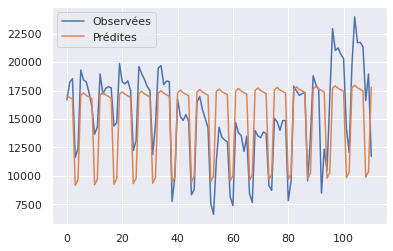

Le RMSE de la méthode Prophet est de 3104 personnes.


In [ ]:
rmse_proph = sqrt(mean_squared_error(Test_proph[['y']],forecast_df[['yhat']]))
plt.plot(proph_test['y'], label="Observées")
plt.plot(forecast_df['yhat'], label="Prédites")
plt.legend()
plt.show()
print("Le RMSE de la méthode Prophet est de {:.0f} personnes.".format(rmse_proph))

Au vu de son RMSE, la méthode Prophet est celle qui se trompe en moyenne le plus parmi toutes les méthodes que nous avons essayé. 
Nous avons décidé de l'implémenter car elle paraissait adaptée à nos besoins (pouvoir prédire des séries temporelles sur un intervalle souhaité). 
Mais pour autant, le résultat de notre backtesting montre que la généralisation de la méthode telle quelle est pauvre, tant au niveau de la tendance que de la volatilité.

## Conclusion sur la modélisation 



Pour conclure nous pouvons affirmer que notre modélisation optimale reste la régression multioutput qui nous permet de réaliser des projections sur 7 jours en fonction des 14 précédents et ce avec une erreur plus faibles qu'en utilisant Prophet. 